# Introduction  
This notebook analyzes paragraphs from the copus 'Emma' in order to identify sentences that are similar among a group of 10 sentences.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Clean and process the data

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma = gutenberg.paras('austen-emma.txt')

#processing
emma_paras = []
for paragraph in emma:
#    print(paragraph)

    para = paragraph[0]
    
    #removing the double-dash from all words
    para = [re.sub(r'--', '', word) for word in para]
    
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))
 #   print(para)

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fred\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Fred\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# Build the Model  

#### Training the model

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=4, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])


Number of features: 1020
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


#### Run the model on test data

In [4]:
#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n_test = X_test_tfidf_csr.shape[0]
print(n_test)

#A list of dictionaries, one per paragraph
tfidf_bypara_test = [{} for _ in range(0,n_test)]

#List of features
terms_test = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara_test[i][terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara_test[5])


949
Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'unexceptionable': 0.34021006165384615, 'assure': 0.2849583443549245, 'friends': 0.26771969260442585, 'quite': 0.20397979981522793, 'replied': 0.21622713776874078, 'watch': 0.6630989315438113, 'elton': 0.17960684463226512, 'pass': 0.302756944818224, 'really': 0.23377239488085674, 'mrs': 0.1573212521757836}


#### Reduce the number of features on the test data

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 949 to 100.
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 49.98315683637081
Component 0:
" Oh !         0.999918
" Oh !         0.999918
" Oh !         0.999918
" Oh !         0.999918
" Oh !         0.999918
" Oh !         0.999918
" Oh !"        0.999918
" Oh !         0.999918
" Me ! oh !    0.999918
" Oh !         0.999918
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.626247
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                               

#### Inspect the sentence similarity

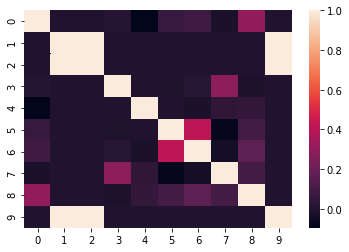

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [6]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)

#Only taking the first 5 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]

#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


# Conclusion and Discussion
Question 0:  Does the test data identify similar sentences (as compared to the training data) for components 0 through 4 ?  

Answer:  The test data does identify similar sentences with similar correlation scores.  However, the comonents do not match up exactly and some sentence are exclusively in training and test data. 

Question 1:  Change some hyperparameters a few times and see how that affects the results of the LSA.  

Observations:  Changing the minimum word frequency from 2 to 4 reduced the number of features from 1948 to 1020.  It also created higher similarity scores for many of the elements in the components.
